# CPSC 8430 Deep Learning Homework 1-2: Optimization
 
### Professor: Feng Luo


**Student First Name, LAST NAME, CUID**:  

Joy, YANG, #C91873986

### Three Subtask
- Visualize the optimization process.
- Observe gradient norm during training.
- What happens when gradient is almost zero?
- Train on designed function, MNIST or CIFAR-10


### Requirement
- Collect weights of the model every n epochs.
- Also collect the weights of the model of different training events.
- Record the accuracy (loss) corresponding to the collected parameters.
- Plot the above results on a figure.

### Visualize the Optimization Process

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F


import copy


from sklearn.decomposition import PCA 
import numpy as np
from matplotlib import pyplot as plt


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. You can run your code on GPU!")
else:
    print("CUDA is not available. Running on CPU instead.")

CUDA is available. You can run your code on GPU!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Training Function and Weight Collection
train_times = 8
num_epochs = 50

grad_all = {}
loss_all = {}
weights_all = {}

for time in range(train_times):
    print(time)

    model = DNNModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    loss_list = []
    grad_list = []
    weights_list = []

    for epoch in range(num_epochs):

        loss_per_epoch = 0
        model = model.to(device)
        model.train()

        # for i, (images, labels) in enumerate(train_loader):
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device).reshape(-1, 28*28)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_per_epoch += loss.item() / len(train_loader)


        if epoch % 3 == 0:
            # store params and loss
            weights_list.append(copy.deepcopy(model.state_dict()))
            loss_list.append(loss_per_epoch)
            
            # compute grad L2 norm
            grad_all_epoch = 0.0
            for p in model.parameters(): 
                grad = 0.0
                if p.grad is not None:
                    grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all_epoch += grad
            grad_norm = grad_all_epoch ** 0.5
            
            # store grad norm
            grad_list.append(grad_norm)

    grad_all[time] = grad_list
    loss_all[time] = loss_list
    weights_all[time] = weights_list


0


1


2


3


4


5


6


7


In [7]:
# Perform PCA and Plotting
n_samples_per_session = len(weights_all[0])
n_samples = train_times * n_samples_per_session 
n_features = weights_all[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] 


PCA_input_data = np.zeros((n_samples, n_features))

#Training and Plotting Process
for t in range(train_times):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = weights_all[t][i]['fc1.weight'].flatten().cpu().numpy()


reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)


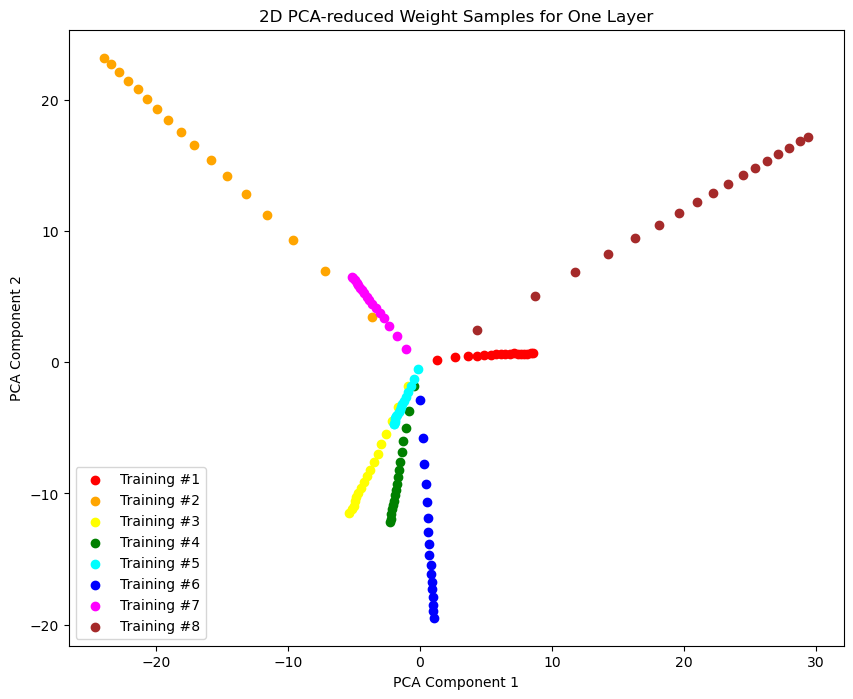

In [8]:
plt.figure(figsize=(10, 8))
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(train_times):
    start_idx = t * n_samples_per_session
    end_idx = (t + 1) * n_samples_per_session
    x_coords = reduced_data.T[0][start_idx:end_idx]
    y_coords = reduced_data.T[1][start_idx:end_idx]
    plt.scatter(x_coords, y_coords, color=colors[t], marker='o', label=f"Training #{t+1}")

plt.legend()
plt.title("2D PCA-reduced Weight Samples for One Layer")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [9]:
n_samples_per_session = len(weights_all[0])
n_samples = train_times * n_samples_per_session 
n_features = weights_all[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] + weights_all[0][0]['fc2.weight'].cpu().numpy().flatten().shape[0] + weights_all[0][0]['fc3.weight'].cpu().numpy().flatten().shape[0]


PCA_input_data = np.zeros((n_samples, n_features))

# populate high-dim input tensor 
for t in range(train_times):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = np.append(weights_all[t][i]['fc1.weight'].flatten().cpu().numpy(), np.append(weights_all[t][i]['fc2.weight'].flatten().cpu().numpy(),weights_all[t][i]['fc3.weight'].flatten().cpu().numpy()))

reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)



In [1]:
plt.figure(figsize=(10, 8))# Define a list of colors for plotting
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]

# Create a scatter plot for each training session
for t in range(train_times):
    # Calculate the index range for the current training session
    idx_range = slice(t * n_samples_per_session, (t + 1) * n_samples_per_session)

    # Scatter plot for the current session's PCA-reduced weights
    plt.scatter(reduced_data[idx_range, 0], reduced_data[idx_range, 1], color=colors[t], marker='o', label=f"Train #{t + 1}")

# Add a legend to the plot
plt.legend()

# Set the title of the plot
plt.title("2D PCA-Reduced Weight Samples for All Layers")
plt.xlabel("All Layer")
# Display the plot
plt.show()


NameError: name 'plt' is not defined